The goal of this project is to study the extent to which Citi Bike usage in New York City is affected by weather.

I used publicly available weather data from a station in Central Park (available here: https://www.ncdc.noaa.gov/cdo-web/) and Citi Bike data available from https://www.citibikenyc.com/system-data.

(0, 25)

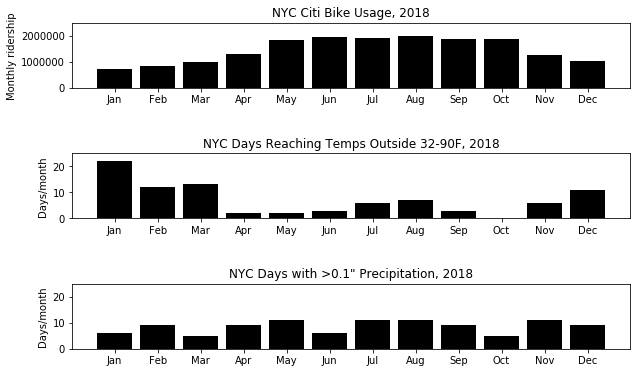

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#Keep track of monthly rides
rides_per_month_2018 = []

#Create a dataframe for each month's data.csv
for month_int in range(1,13):
    month = '0' + str(month_int)
    month_ride_csv = str('2018' + month[-2:] + '-citibike-tripdata.csv')
    df_rides = pd.read_csv(month_ride_csv)
    
    #Count number of bike rides/month
    rides_per_month_2018.append(df_rides.shape[0])  

df_weather = pd.read_csv('Central_Park_weather_2018.csv', usecols=[58,59,60,61])

#Weather dataset has hourly/daily/monthly weather, so isolate monthly rows
monthly_weather = df_weather[df_weather.MonthlyDaysWithGT001Precip > 0]

#Count high precipitation or extreme temp days
extreme_temp_days = []
precipitation_days = []
for index, row in monthly_weather.iterrows():
    extreme_temp_days.append(int(row['MonthlyDaysWithGT32Temp']) + int(row['MonthlyDaysWithGT90Temp']))
    precipitation_days.append(int(row['MonthlyDaysWithGT010Precip']))

#Generate the graphs
fig, axs = plt.subplots(3, figsize=(10,6))
fig.subplots_adjust(hspace=1)

axs[0].set_title('NYC Citi Bike Usage, 2018')
axs[0].set(ylabel='Monthly ridership')
axs[0].bar(months, rides_per_month_2018, color = 'black')
axs[0].set_ylim([0, 2500000])

axs[1].set_title('NYC Days Reaching Temps Outside 32-90F, 2018')
axs[1].set(ylabel='Days/month')
axs[1].bar(months, extreme_temp_days, color = 'black')
axs[1].set_ylim([0, 25])

axs[2].set_title('NYC Days with >0.1" Precipitation, 2018')
axs[2].set(ylabel='Days/month')
axs[2].bar(months, precipitation_days, color = 'black')
axs[2].set_ylim([0, 25])

In [2]:
df_rides.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,689,2018-12-01 00:00:04.3020,2018-12-01 00:11:33.8460,3359.0,E 68 St & Madison Ave,40.769157,-73.967035,164.0,E 47 St & 2 Ave,40.753231,-73.970325,35033,Subscriber,1989,1
1,204,2018-12-01 00:00:05.5330,2018-12-01 00:03:30.5230,3504.0,E 123 St & Lexington Ave,40.802926,-73.937900,3490.0,E 116 St & 2 Ave,40.796879,-73.937261,20501,Subscriber,1966,1
2,316,2018-12-01 00:00:10.2330,2018-12-01 00:05:27.2030,270.0,Adelphi St & Myrtle Ave,40.693083,-73.971789,243.0,Fulton St & Rockwell Pl,40.688226,-73.979382,18386,Subscriber,1984,1
3,726,2018-12-01 00:00:21.9570,2018-12-01 00:12:28.1830,495.0,W 47 St & 10 Ave,40.762699,-73.993012,3660.0,W 16 St & 8 Ave,40.741022,-74.001385,27616,Subscriber,1983,1
4,397,2018-12-01 00:00:29.6320,2018-12-01 00:07:07.4460,473.0,Rivington St & Chrystie St,40.721101,-73.991925,3467.0,W Broadway & Spring Street,40.724947,-74.001659,35096,Subscriber,1976,1


Below, I plotted the total number of rides taken daily during August 2018.

[Text(0, 0.5, 'Ridership')]

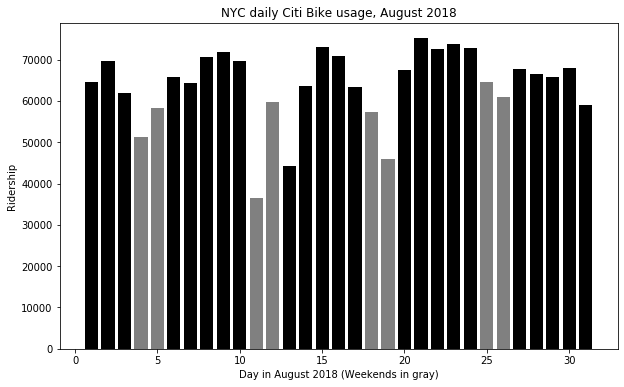

In [3]:
from collections import Counter

#Open dataset
df_rides = pd.read_csv('201808-citibike-tripdata.csv')

#Make a table with only the day of the month each ride took place
august_rides = df_rides.apply(lambda row: int(row['starttime'][8:10]), axis=1)

#List of days
days = list(range(1,32))

#Count the rides that took place on each day
counter = Counter(august_rides)
rides_per_day = [counter[i] for i in range(1,1+len(counter))]

#August 4 = First Saturday in August
first_weekend_day = 4

#For distinguishing weekdays/weekends on the graph
colors = []
for i in days:
    if (i % 7) == first_weekend_day or (i % 7) == (1 + first_weekend_day):
        colors.append('gray')
    else:
        colors.append('black')

#Generate the graph
fig, ax = plt.subplots(1, figsize=(10,6))

ax.bar(days, rides_per_day, color = colors)
ax.set_title('NYC daily Citi Bike usage, August 2018')
ax.set(xlabel = 'Day in August 2018 (Weekends in gray)')
ax.set(ylabel = 'Ridership')

From the graph above, it appears as though ridership is lower on the weekends, potentially because riders who use CitiBike to commute to work during the week stay home (they must not be PhD students). 

To determine if lower weekend ridership is due to reduced rush hour Citi Bike use, I will split the daily rides into 5 timeslots: 12-6AM, 6-9AM, 9-4PM, 4-7PM, 7-12AM (Night, Morning, Day, Afternoon, and Evening).

Below, I plotted stacked bar graphs of daily rides. I expect that they will show a significant reduction in rush hour ridership, whereas other times of day might be less affected.

[Text(0, 0.5, 'Ridership during 5 daily segments. Night->Evening')]

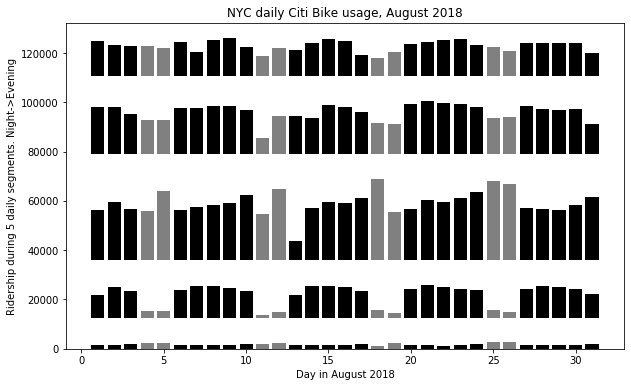

In [4]:
#Generate 5 numpy arrays of rides from different parts of the day
def numpify_daily_segments(ride_day_segments)->'List[5]':
    numpy_rides_per_day = np.array(ride_day_segments)

    ride_segments = []
    for i in range(5):
        ride_segments.append(numpy_rides_per_day[:,i])
    return ride_segments

#Make a table with the hour and day of each ride
rides_time_of_day = df_rides.apply(lambda row: [int(row['starttime'][8:10]),int(row['starttime'][11:13])], axis=1)

#Keep track of rides taking place during [night, morning, day, afternoon, evening]
#ith entry represents ith day within month
rides_per_day_segment = [[0,0,0,0,0] for i in range(31)]

for i in rides_time_of_day:
    time_of_day = -1
    if i[1] < 6:
        time_of_day = 0
    elif i[1] < 9:
        time_of_day = 1
    elif i[1] < 16:
        time_of_day = 2
    elif i[1] < 19:
        time_of_day = 3
    else:
        time_of_day = 4
        
    rides_per_day_segment[i[0]-1][time_of_day] += 1

#Generate numpy arrays for plotting
seg_rides = numpify_daily_segments(rides_per_day_segment)

#Generate the graphs
fig, ax = plt.subplots(1, figsize=(10,6))

#Separate stacked bars to better compare columns
ax.bar(days, seg_rides[0], color = colors)
ax.bar(days, seg_rides[1], bottom = (10000
                                     + max(seg_rides[0])), color = colors)
ax.bar(days, seg_rides[2], bottom = (20000
                                     + max(seg_rides[0])
                                     + max(seg_rides[1])), color = colors)
ax.bar(days, seg_rides[3], bottom = (30000
                                     + max(seg_rides[0])
                                     + max(seg_rides[1])
                                     + max(seg_rides[2])), color = colors)
ax.bar(days, seg_rides[4], bottom = (40000
                                     + max(seg_rides[0])
                                     + max(seg_rides[1])
                                     + max(seg_rides[2])
                                     + max(seg_rides[3])), color = colors)

ax.set_title('NYC daily Citi Bike usage, August 2018')
ax.set(xlabel = 'Day in August 2018')
ax.set(ylabel = 'Ridership during 5 daily segments. Night->Evening')

Morning rush hour weekday:weekend comparison:
Ttest_indResult(statistic=27.55148948504234, pvalue=4.813586908790505e-20)
Midday weekday:weekend comparison:
Ttest_indResult(statistic=-1.8675264197095482, pvalue=0.09428761805948907)
Evening rush hour weekday:weekend comparison:
Ttest_indResult(statistic=4.790758859064704, pvalue=0.0008026931959053377)


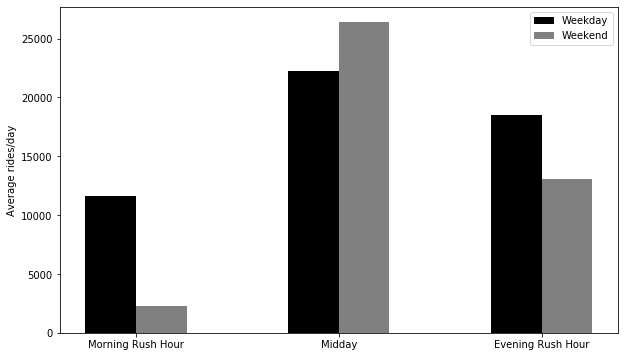

In [5]:
from scipy import stats

weekday = [[],[],[]]
weekend = [[],[],[]]

for i in days:
    if (i % 7) == first_weekend_day or (i % 7) == (1 + first_weekend_day):
        for j in range(3):
            weekend[j].append(rides_per_day_segment[i-1][j+1])
    else:
        for j in range(3):
            weekday[j].append(rides_per_day_segment[i-1][j+1])
            
#Generate the graphs
fig, ax = plt.subplots(1, figsize=(10,6))

weekday_avgs = [sum(weekday[0])/len(weekday[0]),
               sum(weekday[1])/len(weekday[1]),
               sum(weekday[2])/len(weekday[2])]

weekend_avgs = [sum(weekend[0])/len(weekend[0]),
               sum(weekend[1])/len(weekend[1]),
               sum(weekend[2])/len(weekend[2])]

pos1 = np.arange(3)
pos2 = np.arange(3) + 0.25

ax.bar(pos1, weekday_avgs, width = 0.25, color = 'black')
ax.bar(pos2, weekend_avgs, width = 0.25, color = 'gray')
ax.set_xticks([0.125, 1.125, 2.125])
ax.set_xticklabels(['Morning Rush Hour', 'Midday', 'Evening Rush Hour'])
ax.set(ylabel = 'Average rides/day')
ax.legend(['Weekday', 'Weekend'], bbox_to_anchor=(1,1))

            
print('Morning rush hour weekday:weekend comparison:')
print(stats.ttest_ind(weekday[0], weekend[0], equal_var = False))

print('Midday weekday:weekend comparison:')
print(stats.ttest_ind(weekday[1], weekend[1], equal_var = False))

print('Evening rush hour weekday:weekend comparison:')
print(stats.ttest_ind(weekday[2], weekend[2], equal_var = False))

The stacked bar graph above shows there is less ridership during the morning and evening rush hours on weekends. This is made up for by slightly increased ridership during the day (9AM-4PM). Below, I present this data as a percent of total daily rides.

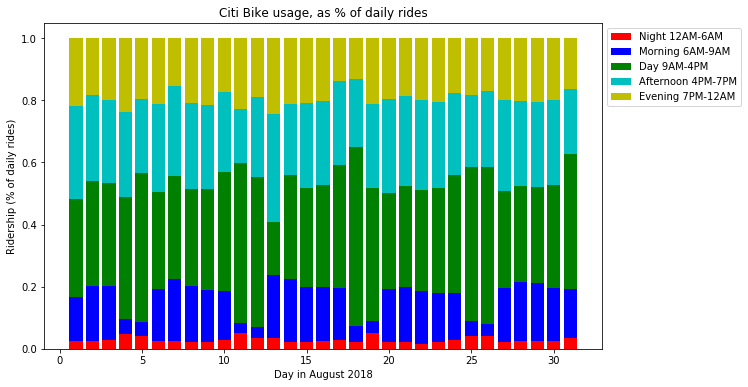

In [6]:
#Calculate % of daily rides
#Replaces number of rides/daily segment by fraction of daily rides during that segment
for j in rides_per_day_segment:
    total_rides = sum(j)
    for k in range(len(j)):
        j[k] = float(j[k])/float(total_rides)        

#Generate arrays for plotting
seg_rides = numpify_daily_segments(rides_per_day_segment)

#Generate the graphs
fig, ax = plt.subplots(1, figsize=(10,6))

ax.bar(days, seg_rides[0], color = 'r')
ax.bar(days, seg_rides[1], bottom = seg_rides[0], color = 'b')
ax.bar(days, seg_rides[2], bottom = (seg_rides[0]
                                      + seg_rides[1]), color = 'g')
ax.bar(days, seg_rides[3], bottom = (seg_rides[0]
                                      + seg_rides[1] 
                                      + seg_rides[2]), color = 'c')
ax.bar(days, seg_rides[4], bottom = (seg_rides[0]
                                      + seg_rides[1]                                   
                                      + seg_rides[2] 
                                      + seg_rides[3]), color = 'y')

ax.set_title('Citi Bike usage, as % of daily rides')
ax.set(xlabel = 'Day in August 2018')
ax.set(ylabel = 'Ridership (% of daily rides)')
ax.legend(['Night 12AM-6AM','Morning 6AM-9AM','Day 9AM-4PM','Afternoon 4PM-7PM','Evening 7PM-12AM'], bbox_to_anchor=(1,1))

(0, 120000)

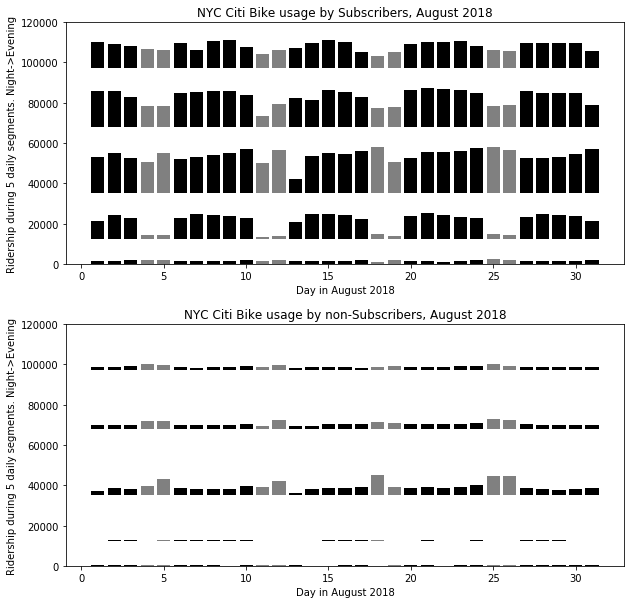

In [7]:
#Make a table with the hour, day, and user type of each ride
rides_time_of_day_user = df_rides.apply(lambda row: [int(row['starttime'][8:10]),int(row['starttime'][11:13]), str(row['usertype'])], axis=1)

#Keep track of rides taking place during [night, morning, day, afternoon, evening]
#ith entry represents ith day within month
customer_rides_per_day = [[0,0,0,0,0] for i in range(31)]
subscriber_rides_per_day = [[0,0,0,0,0] for i in range(31)]

for i in rides_time_of_day_user:
    time_of_day = -1
    if i[1] < 6:
        time_of_day = 0
    elif i[1] < 9:
        time_of_day = 1
    elif i[1] < 16:
        time_of_day = 2
    elif i[1] < 19:
        time_of_day = 3
    else:
        time_of_day = 4
        
    if i[2] == 'Customer':
        customer_rides_per_day[i[0]-1][time_of_day] += 1
    else:
        subscriber_rides_per_day[i[0]-1][time_of_day] += 1

#Generate numpy arrays for plotting
sub_seg_rides = numpify_daily_segments(subscriber_rides_per_day)

cust_seg_rides = numpify_daily_segments(customer_rides_per_day)

#Generate the graphs
fig, axs = plt.subplots(2, figsize=(10,10))
fig.subplots_adjust(hspace=0.25)

axs[0].bar(days, sub_seg_rides[0], color = colors)
axs[0].bar(days, sub_seg_rides[1], bottom = (10000
                                      + max(sub_seg_rides[0])), color = colors)
axs[0].bar(days, sub_seg_rides[2], bottom = (20000
                                      + max(sub_seg_rides[0])
                                      + max(sub_seg_rides[1])), color = colors)
axs[0].bar(days, sub_seg_rides[3], bottom = (30000
                                      + max(sub_seg_rides[0])
                                      + max(sub_seg_rides[1])
                                      + max(sub_seg_rides[2])), color = colors)
axs[0].bar(days, sub_seg_rides[4], bottom = (40000
                                      + max(sub_seg_rides[0])
                                      + max(sub_seg_rides[1])
                                      + max(sub_seg_rides[2])
                                      + max(sub_seg_rides[3])), color = colors)

axs[0].set_title('NYC Citi Bike usage by Subscribers, August 2018')
axs[0].set(ylabel='Ridership during 5 daily segments. Night->Evening')
axs[0].set(xlabel='Day in August 2018')
axs[0].set_ylim([0, 120000])

axs[1].bar(days, cust_seg_rides[0], color = colors)
axs[1].bar(days, cust_seg_rides[1], bottom = (10000
                                      + max(sub_seg_rides[0])), color = colors)
axs[1].bar(days, cust_seg_rides[2], bottom = (20000
                                      + max(sub_seg_rides[0])
                                      + max(sub_seg_rides[1])), color = colors)
axs[1].bar(days, cust_seg_rides[3], bottom = (30000
                                      + max(sub_seg_rides[0])
                                      + max(sub_seg_rides[1])
                                      + max(sub_seg_rides[2])), color = colors)
axs[1].bar(days, cust_seg_rides[4], bottom = (40000
                                      + max(sub_seg_rides[0])
                                      + max(sub_seg_rides[1])
                                      + max(sub_seg_rides[2])
                                      + max(sub_seg_rides[3])), color = colors)

axs[1].set_title('NYC Citi Bike usage by non-Subscribers, August 2018')
axs[1].set(ylabel = 'Ridership during 5 daily segments. Night->Evening')
axs[1].set(xlabel = 'Day in August 2018')
axs[1].set_ylim([0, 120000])